### 1) Imports

In [1]:
# https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20QUBO%20problem.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse
from pulser import Sequence
from pulser import Register

from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform

from pulser_simulation import Simulation

from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.style.use('dark_background')

In [3]:
coupling_matrix = np.array(
    [
        [-10.0,      19.7365809,  19.7365809,  5.42015853, 5.42015853],
        [19.7365809, -10.0,       20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0,       0.85604541, 0.17675796],
        [5.42015853, 0.17675796,  0.85604541,  -10.0,      0.32306662],
        [5.42015853, 0.85604541,  0.17675796,  0.32306662, -10.0     ],
    ]
)

In [4]:
# # Load Protein QUBO

# loaded_qubo = np.load('qubo_proteins.npy')

# coupling_matrix = loaded_qubo

# loaded_qubo.shape

### 2) Classical Search

In [5]:
coupling_matrix_size = len(coupling_matrix)

state_indices = np.arange(2 ** coupling_matrix_size)

binarize = np.vectorize(np.binary_repr)

state_strings = binarize(state_indices, coupling_matrix_size)

state_strings

array(['00000', '00001', '00010', '00011', '00100', '00101', '00110',
       '00111', '01000', '01001', '01010', '01011', '01100', '01101',
       '01110', '01111', '10000', '10001', '10010', '10011', '10100',
       '10101', '10110', '10111', '11000', '11001', '11010', '11011',
       '11100', '11101', '11110', '11111'], dtype='<U5')

In [6]:
state_indices_vector = state_indices.reshape(-1, 1).astype(np.uint8)

state_little_bits = np.unpackbits(state_indices_vector, 
                                  count=coupling_matrix_size, 
                                  bitorder='little',
                                  axis=1)

state_bits = np.flip(state_little_bits, axis=1)

state_bits.shape

(32, 5)

In [7]:
costs = np.diag(state_bits @ coupling_matrix @ state_bits.T)

In [8]:
state_costs = zip(state_strings, costs)

top_state_costs = sorted(state_costs, key=lambda x: x[1])

print("top_state_costs:", top_state_costs[:3])

top_state_costs: [('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


### 3) Embedding to Atomic Register

In [9]:
def evaluate_mapping(coordinate_vector, coupling_matrix, shape):  
    
    coordinates = np.reshape(coordinate_vector, shape)
    
    pairwise_distances = pdist(coordinates)
    
    interaction_matrix = squareform(Chadoq2.interaction_coeff /  pairwise_distances ** 6)
    
    root_mean_square_error = np.linalg.norm(interaction_matrix - coupling_matrix)
    
    return root_mean_square_error

In [10]:
np.random.seed(0)

In [11]:
coordinates_shape = (coupling_matrix_size, 2)

initial_coordinates = np.random.random(coordinates_shape)

initial_coordinate_vector = initial_coordinates.flatten()

In [12]:
optimal_coordinates_result = minimize(
    fun=evaluate_mapping,
    x0=initial_coordinate_vector,
    args=(coupling_matrix, coordinates_shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

In [13]:
optimal_coordinates = np.reshape(optimal_coordinates_result.x, coordinates_shape)

optimal_coordinates

array([[ 5.43591935,  1.83221016],
       [ 5.30433156, -6.2289737 ],
       [-1.57590666, -2.14702291],
       [ 1.61714433, 11.07433973],
       [15.37762057,  2.91043984]])

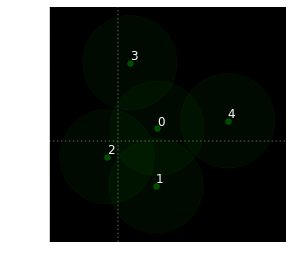

In [14]:
qubits_dict = dict(enumerate(optimal_coordinates))

atomic_register = Register(qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

$$ H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j} ... $$

### 4) Quantum Adiabatic Algorithm (QAA)

In [15]:
# Omega Maximum

positive_coupling_coefficients = coupling_matrix[coupling_matrix > 0].flatten()

omega_maximum = np.median(positive_coupling_coefficients)

omega_maximum

3.13810197

In [16]:
DELTA_0 = -5
DELTA_F = -DELTA_0

TIME_NANOSECONDS = 4000

In [17]:
# Modulating Waveforms

amplitude_modulating_waveform = InterpolatedWaveform(TIME_NANOSECONDS, [1e-9, omega_maximum, 1e-9])

frequency_modulating_waveform = InterpolatedWaveform(TIME_NANOSECONDS, [DELTA_0, 0, DELTA_F])

In [18]:
# Pulse

adiabatic_pulse = Pulse(
    amplitude=amplitude_modulating_waveform,
    detuning=frequency_modulating_waveform,
    phase=0,
)

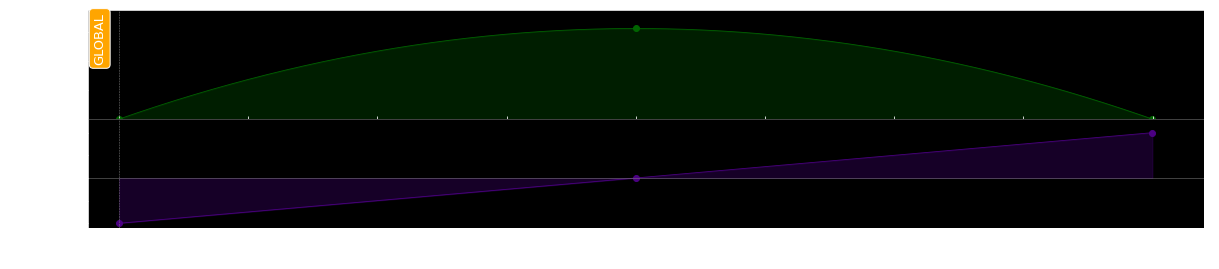

In [19]:
sequence = Sequence(atomic_register, Chadoq2)
sequence.declare_channel("ising", "rydberg_global")
sequence.add(adiabatic_pulse, "ising")
sequence.draw()

In [47]:
simulation = Simulation(sequence)

results = simulation.run()

final_statevector = results.get_final_state()

counts = results.sample_final_state()

counts


Counter({'00001': 1,
         '00011': 15,
         '00100': 1,
         '00101': 3,
         '00111': 477,
         '01000': 2,
         '01010': 4,
         '01011': 491,
         '10000': 6})

In [101]:
def plot_distribution(counts):
    
    descending_counts = dict(sorted(counts.items(), key=lambda item: -item[1]))
    
    indexes = ["01011", "00111"]  # MIS indexes
    
    color_dict = {key: "r" if key in indexes else "g" for key in descending_counts}
    
    plt.figure(figsize=(12, 6))
    # plt.bar(descending_counts.keys(), descending_counts.values(), width=0.5, color=color_dict.values())
    
    plt.bar(*zip(*descending_counts.items()), width=0.5, color=color_dict.values())
    
    plt.xticks(rotation="vertical")
    plt.title("Simulated state counts")
    plt.xlabel("State")
    plt.ylabel("Count")
    plt.show()
    
    # print(**list(zip(*descending_counts.items())))

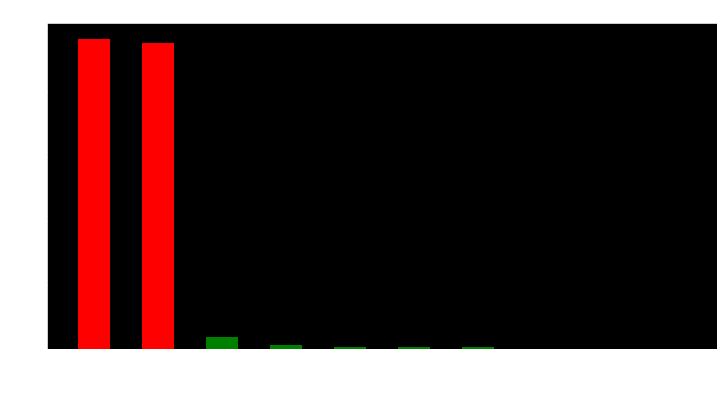

In [102]:
plot_distribution(count_dict)

In [24]:
# We choose a median value between the min and the max

Omega = np.median(coupling_matrix[coupling_matrix > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information i

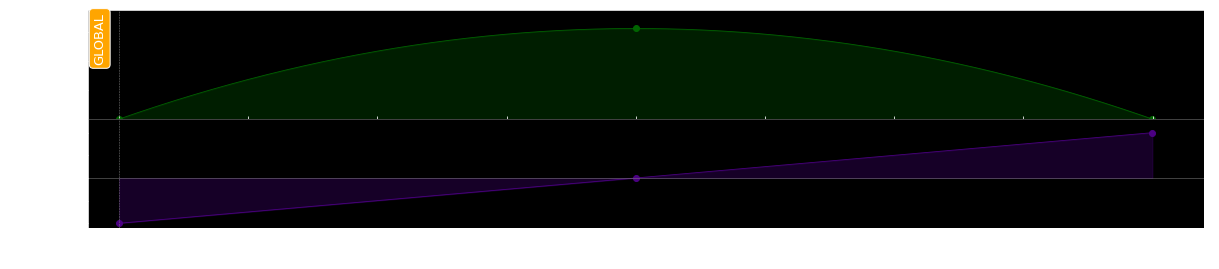

In [25]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(atomic_register, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [50]:
simul = Simulation(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

NameError: name 'seq' is not defined

In [49]:
# plot_distribution(count_dict)

#### Time Evolution

In [28]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(atomic_register, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = Simulation(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, coupling_matrix) / 3)

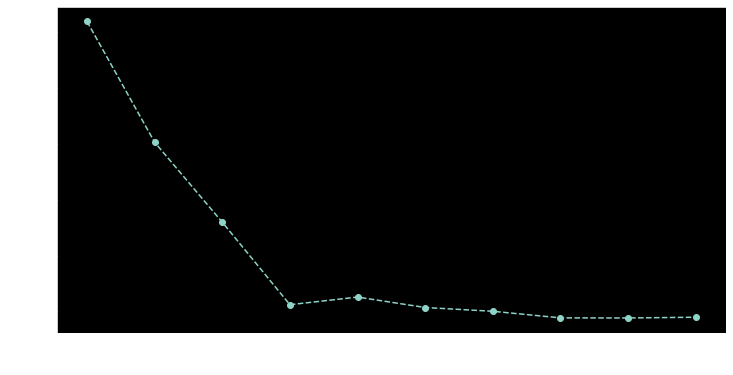

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

### 5) QAOA

In [14]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(atomic_register, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [15]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [16]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [17]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

In [18]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

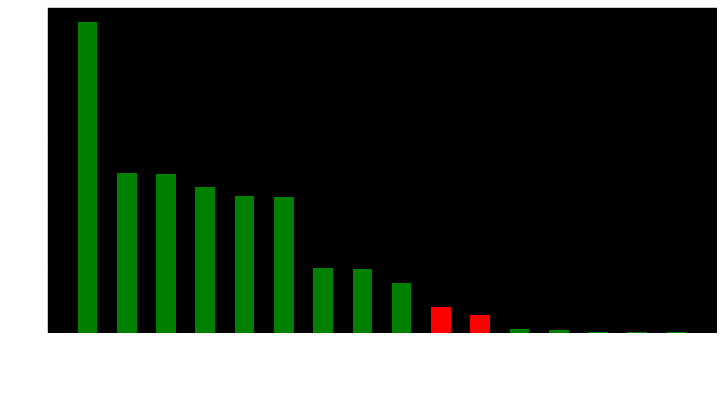

In [19]:
plot_distribution(example_dict)

#### Optimization

In [20]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

#### QAOA

In [21]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [22]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
    
        res = minimize(
            func,
            args=coupling_matrix,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    
    except Exception as e:
        pass

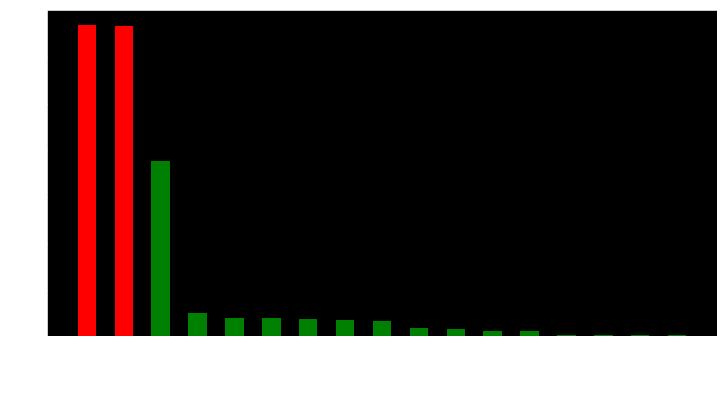

In [23]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)